In [1]:
import os
import pandas as pd
import numpy as np
import datetime
import json
import matplotlib.pyplot as plt

In [2]:
data_folder = "data/data/"
cpu_util_file = "node_cpu_seconds_total_2024-03-07 00:37:45.083133.csv"
node_package_power_file = "kepler_node_package_joules_total_2024-03-07 00:38:22.558554.csv"
node_dram_power_file = "kepler_node_dram_joules_total_2024-03-07 00:38:21.492959.csv"

In [3]:
cpu_util = pd.read_csv(data_folder+cpu_util_file)
cpu_util = cpu_util[cpu_util['mode']!='idle']
cpu_util_agg = cpu_util.groupby(['instance', 'timestamp'], as_index=False)['value'].sum()
cpu_util_agg['timestamp'] = pd.to_datetime(cpu_util_agg['timestamp'])

node_package_power = pd.read_csv(data_folder+node_package_power_file)
node_package_power = node_package_power.groupby(['instance', 'timestamp'], as_index=False)['value'].sum()
node_package_power['timestamp'] = pd.to_datetime(node_package_power['timestamp'])

node_dram_power = pd.read_csv(data_folder+node_dram_power_file)
node_dram_power = node_dram_power.groupby(['instance', 'timestamp'], as_index=False)['value'].sum()
node_dram_power['timestamp'] = pd.to_datetime(node_dram_power['timestamp'])

In [4]:
node_power_metrics = pd.merge(node_package_power, node_dram_power, on = ["timestamp", "instance"])
node_power_metrics = node_power_metrics.rename(columns={"value_x":"package", "value_y":"dram"})
node_power_metrics['power'] = node_power_metrics['package'] + node_power_metrics['dram']

In [5]:
n1 = cpu_util_agg[cpu_util_agg['instance'] == 'tantawi1']
n1['value'] = n1['value'].diff()
n1_pow = node_power_metrics[node_power_metrics['instance'] == "tantawi1"]
n1_pow['power'] = n1_pow['power'].diff()
n1_data = pd.merge_asof(n1, n1_pow, on = 'timestamp')
n1_data['energy'] = n1_data['package'] + n1_data['dram']

n2 = cpu_util_agg[cpu_util_agg['instance'] == 'tantawi2']
n2['value'] = n2['value'].diff()
n2_pow = node_power_metrics[node_power_metrics['instance'] == "tantawi2"]
n2_pow['power'] = n2_pow['power'].diff()
n2_data = pd.merge_asof(n2, n2_pow, on = 'timestamp')
n2_data['energy'] = n2_data['package'] + n2_data['dram']

/var/folders/42/cvcgsrbd5fgbmc436n0pvpxm0000gn/T/ipykernel_77995/2975578211.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  n1['value'] = n1['value'].diff()
/var/folders/42/cvcgsrbd5fgbmc436n0pvpxm0000gn/T/ipykernel_77995/2975578211.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  n1_pow['power'] = n1_pow['power'].diff()
/var/folders/42/cvcgsrbd5fgbmc436n0pvpxm0000gn/T/ipykernel_77995/2975578211.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

In [6]:
n1_peaks = n1_data.iloc[1080:1720, :]
n1_peaks.reset_index(inplace=True, drop=True)
n2_peaks = n2_data.iloc[1080:1720, :]
n2_peaks.reset_index(inplace=True, drop=True)

In [7]:
n1_default = n1_data.iloc[1760:, :]
n1_default.reset_index(inplace=True, drop=True)
n2_default = n2_data.iloc[1760:, :]
n2_default.reset_index(inplace=True, drop=True)

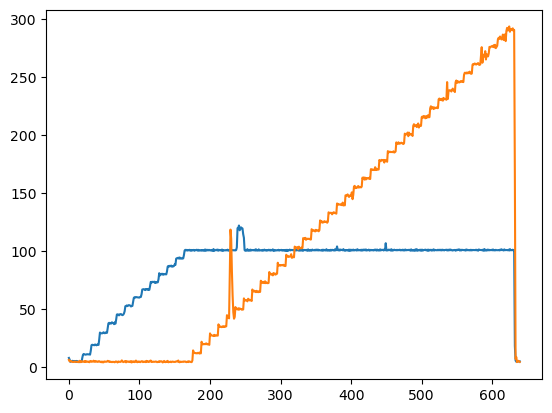

In [8]:
plt.plot(n1_peaks['value'])
plt.plot(n2_peaks['value'])

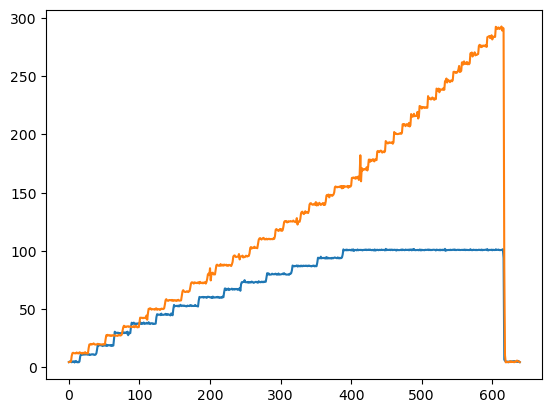

In [9]:
plt.plot(n1_default['value'])
plt.plot(n2_default['value'])

In [10]:
time = 10
energy_peaks = []
for i in range(time, len(n1_peaks)-1, time):
    energy_peaks.append((n1_peaks['energy'][i] - n1_peaks['energy'][i-time])+(n2_peaks['energy'][i] - n2_peaks['energy'][i-time]))
    
energy_default = []
for i in range(time, len(n1_default)-1, time):
    energy_default.append((n1_default['energy'][i] - n1_default['energy'][i-time])+(n2_default['energy'][i] - n2_default['energy'][i-time]))

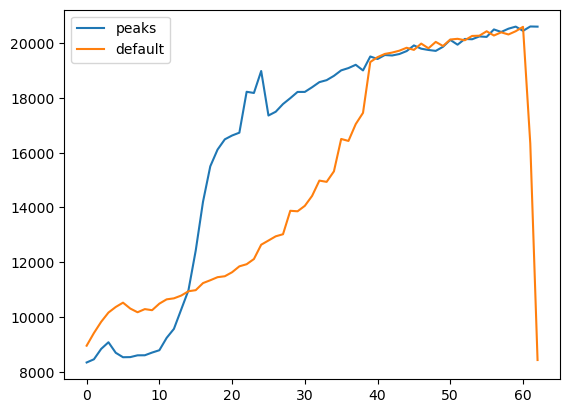

In [12]:
plt.plot(energy_peaks)
plt.plot(energy_default)
plt.legend(['peaks', 'default'])